In [10]:
import os
import mido
import utils ##
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

Datos preprocesados:
https://drive.google.com/drive/folders/1jzfK-VM_Qb76K31Y7iMpsi1JeQ7QqU5W?usp=sharing

# Importar Datos

In [11]:
df_midis_info = pd.read_csv('datos_procesados/midis/midis_info.csv', index_col=0)
df_midis_notas = pd.read_csv('datos_procesados/midis/midis_notas.csv', index_col=0)

In [12]:
# Tipos de MIDI
df_non_standard = pd.read_csv('datos_procesados/midis/tipos/no_estandar.csv', index_col=0)
df_standard = pd.read_csv('datos_procesados/midis/tipos/estandar.csv', index_col=0)

In [13]:
# Usar los audios con expresión MIDI estándar
df_midi = df_standard.merge(df_midis_info, how='left', left_index=True, right_index=True)
df_midi = df_midi.drop(columns=['problem?'])
df_midi = df_midi.rename({'velocity':'velocity_start'}, axis=1)

df_notas = df_midis_notas.loc[df_midi.index]

In [14]:
# Guardar la información de las muestras válidas
df_midi.to_csv('datos_procesados/valid_samples.csv')

# MIDIS

In [15]:
lowest_time = df_midi.min_time.min()
print(lowest_time, 's')

0.125 s


### Filtrar frecuencias
Sólo se conservan aquellas que son alcanzables por una voz humana

In [16]:
### Filtra notas que no son ejecutadas
notas_mask = (df_notas.sum() > 0)
notas_ejecutadas = notas_mask[notas_mask]

# Transforma en DataFrame
notas_ejecutadas = notas_ejecutadas.index.str.extract('(^\d+) \((\w#?\d)\)') # Separa la clave MIDI del Cifrado
notas_ejecutadas = notas_ejecutadas.rename({0:'midi-ET', 1: 'cifrado'}, axis=1) # Renombrar
notas_ejecutadas['midi-ET'] = notas_ejecutadas['midi-ET'].astype(int) # Regresar a numérico
notas_ejecutadas['herts-ET'] = utils.preprocess.nota_a_frequencia(notas_ejecutadas['midi-ET']) # Convertir a frecuencia

In [17]:
# Calcular cotas de filtrado
hz_std = notas_ejecutadas['herts-ET'].std() 

hz_lb = np.floor( notas_ejecutadas['herts-ET'].min() * (1-0.5) )
hz_ub = np.ceil( notas_ejecutadas['herts-ET'].max() + 0.5*hz_std )

freq_range = (hz_lb, hz_ub)
print(f'Rango de frecuencias utilizable (Hz): {freq_range}')

Rango de frecuencias utilizable (Hz): (18.0, 1167.0)


### Reducción dimensión de tiempo

La reducción se realiza a un tiempo $T$ siguiendo los siguientes pasos para garantizar la integridad de las notas:

- Recortar tiempo muerto al inicio del MIDI
- Encontrar el punto de corte en $T$ del MIDI
- Verificar si hay una nota sonando
- Eliminar la nota sonando
- Capturar el tiempo $t_f$ en la que termina la última nota ($t_f \leq 10$)

In [23]:
def procesar_midis(midi_names, output_folder, T):
    """
    Aplica las funciones de recorte de desfase de tiempo inicial (lstrip) y ajuste a T segundos 
    a todos los archivos MIDI en una carpeta.
    
    Parámetros:
        midi_names (Series): Nombres de los MIDI a convertir.
        output_folder (str): Carpeta de destino para guardar los archivos MIDI procesados.
        T (float): Duración máxima en segundos para los archivos MIDI procesados.
    """
    # Revisar carpeta de salida
    os.makedirs(output_folder, exist_ok=True)
    # Definir carpeta de MIDIs
    input_folder = 'datos/MIDIs/midi_data/'

    
    for midi_name in midi_names:
        midi_path = os.path.join(input_folder, midi_name + '.mid')
        mid = mido.MidiFile(midi_path)
        
        # Recortar tiempo muerto
        mid = utils.midi.lstrip(mid)
        
        # Recortar duración a T segundos
        tempo = df_midi['tempo_ms'].loc[midi_name]
        mid = utils.midi.trim(mid, tempo, T)
        
        # Guardar el archivo MIDI procesado
        output_path = os.path.join(output_folder, midi_name + '.mid')
        mid.save(output_path)


In [24]:
procesar_midis(midi_names=df_midi.index,
               output_folder='datos_procesados/midis/trimmed/',
               T=10)

### MIDI 2 vector

In [8]:
def crear_vectores(midi_names, output_folder, N, T):
    """
    Convierte todos los midi ingresados a vector, siguiendo los criterios de asignación:
    `vec[i] -> comienzo del evento`
    `vec[i+1] -> Duración L_segs del evento` 
    Esto implica que si una nota deja de sonar en la casilla [i], esa casilla se marcará con "0", 
    pues se considera que consumió la casilla i-1 y terminó al inicio de la casilla i.
    
    Parámetros:
        midi_names (Series): Nombres de los MIDI a convertir.
        output_folder (str): Carpeta de destino para guardar los vectores MIDI.
        N (int): Longitud del vector MIDI (normalmente del tamaño de ventanas temporales)
        T (float): Duración máxima en segundos que codifica el vector
    """
    # Revisar carpeta de salida
    os.makedirs(output_folder, exist_ok=True)
    # Definir carpeta de MIDIs
    input_folder = 'datos_procesados/midis/trimmed/'

    
    for midi_name in midi_names:
        midi_path = os.path.join(input_folder, midi_name + '.mid')
        mid = mido.MidiFile(midi_path)
        
        # Transformar a vector
        vector = utils.midi.midi2vec(mid, N, T)
        
        # Guardar vector
        output_vect_path = os.path.join(output_folder, midi_name + '_target.npy')
        np.save(output_vect_path, vector)


In [ ]:
crear_vectores(midi_names=df_midi.index,
               output_folder='datos_procesados/midis/target_vectors/',
               N=int(10 / (lowest_time/2)),
               T=10)

- Dimensión de vectores

El máximo debe ser de 160 pues $\text{sr} / (\text{lowest\_time} / 2) = 160$. Las que son menores a este valor, es debido a que los audios son más cortos.

In [10]:
folder_path = 'datos_procesados/midis/target_vectors/'
names = []
shapes = []
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    data = np.load(file_path)
    names.append(filename)
    shapes.append(data.shape)

In [11]:
window_shapes = pd.DataFrame(shapes, index = names)
window_shapes.describe()

,0
count,10053.000000
mean,143.427932
std,12.131464
min,80.000000
25%,137.000000
50%,145.000000
75%,152.000000
max,160.000000


# Tarareos


In [18]:
def procesar_tarareos(audio_names, output_folder_frames, output_folder_espectros, L_seg, freq_range):
    """
    Procesa todos los archivos de audio seleccionados, aplicando recorte, 
    división en ventanas y generación de espectrogramas.
    
    Parámetros:
        audio_names (Series): Nombres de los audios a procesar.
        output_folder_frames (str): Carpeta para guardar los arreglos de ventanas de audio procesados.
        output_folder_espectros (str): Carpeta para guardar los espectrogramas generados.
        L_seg (float): Duración de cada ventana en segundos.
        freq_range (tuple): Rango de frecuencias a considerar (min_freq, max_freq).
    """
    # Librería de transformación de tarareos
    audio = utils.tarareos
    # Crear carpetas de salida si no existen
    os.makedirs(output_folder_frames, exist_ok=True)
    os.makedirs(output_folder_espectros, exist_ok=True)
    # Definir carpeta de tarareos
    input_folder = 'datos/Tarareos/wav_data_sync_with_midi/'
    midi_folder = 'datos_procesados/midis/trimmed/' # Los ya procesados
    final_freqs = {}

    for audio_name in audio_names:
        audio_path = os.path.join(input_folder, audio_name + '.wav')
        y, sr = librosa.load(audio_path)
        mid = mido.MidiFile(midi_folder + audio_name + '.mid')
        T_midi = mid.length

        # Recortar el audio
        y_recortado = audio.trim(y, sr, T_midi, top_db=55) #, top_db=-55
        
        ### VENTANAS
        # Amplitud positiva (magnitud) y Normalizar
        y_abs = np.abs(y_recortado)
        y_norm = (y - np.min(y_abs)) / (np.max(y_abs) - np.min(y_abs))

        audio_frames, L = audio.dividir_en_ventanas(y_norm, sr, L_seg)

        output_frame_path = os.path.join(output_folder_frames, audio_name + '_frames.npy')
        np.save(output_frame_path, audio_frames)
        
        ### ESPECTROGRAMA
        espectrograma, _freqs = audio.espectrograma(y_recortado, sr, L, freq_range)
        final_freqs[audio_name] = _freqs
    
        output_espectro_path = os.path.join(output_folder_espectros, audio_name + '_espectrograma.npy')
        # print(espectrograma.shape)
        np.save(output_espectro_path, espectrograma)

In [19]:
procesar_tarareos(audio_names=df_midi.index,
                  output_folder_frames='datos_procesados/tarareos/ventanas/',
                  output_folder_espectros='datos_procesados/tarareos/espectrogramas/',
                  L_seg=lowest_time/2,
                  freq_range=freq_range)

In [257]:
#### Muestras
# T_audio > 10 : F04_0300_0001_1_D
# T_audio = 10 : F01_0009_0001_2_D
# T_audio < 10 : F01_0035_0001_2_D
# Nota sonando en T : F01_0028_0003_2_D
# Nota no sonando en T: F01_0022_0001_1_D

- Dimensiones de ventanas

In [15]:
folder_path = 'datos_procesados/tarareos/ventanas/'
names = []
shapes = []
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    data = np.load(file_path)
    names.append(filename)
    shapes.append(data.shape)

In [19]:
window_shapes = pd.DataFrame(shapes, index = names)
window_shapes.describe()

,0,1
count,10053.0,10053.000000
mean,1378.0,150.395106
std,0.0,10.921703
min,1378.0,73.000000
25%,1378.0,146.000000
50%,1378.0,154.000000
75%,1378.0,157.000000
max,1378.0,230.000000


- Dimensiones de espectrogramas

In [20]:
folder_path = 'datos_procesados/tarareos/espectrogramas/'
names = []
shapes = []
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    data = np.load(file_path)
    names.append(filename)
    shapes.append(data.shape)

In [21]:
espectro_shapes = pd.DataFrame(shapes, index = names)
espectro_shapes.describe()

,0,1
count,10053.0,10053.000000
mean,70.0,151.395106
std,0.0,10.921703
min,70.0,74.000000
25%,70.0,147.000000
50%,70.0,155.000000
75%,70.0,158.000000
max,70.0,231.000000


# Otros

- Test window normalization values (input arrays)

In [52]:
foo = np.load('datos_procesados/tarareos/ventanas/F01_0004_0001_1_D_frames.npy')

In [53]:
pd.Series(foo.reshape(-1)).describe()

count    2.204800e+05
mean     6.240104e-08
std      8.613486e-02
min     -3.978373e-01
25%     -3.326048e-02
50%     -9.359404e-05
75%      2.069025e-02
max      4.222424e-01
dtype: float64

<Axes: >

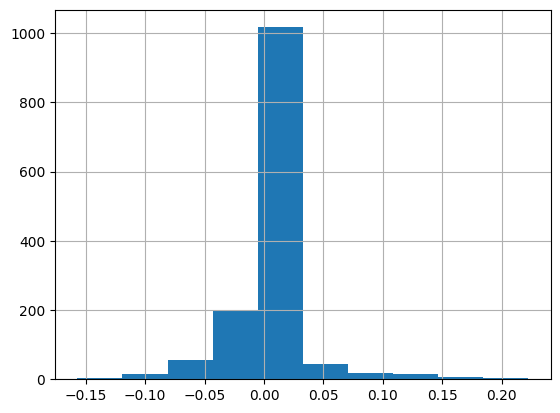

In [54]:
pd.Series(foo[:,0]).hist()

<Axes: >

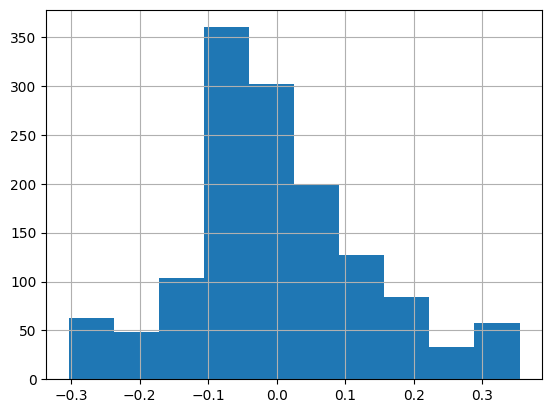

In [56]:
pd.Series(foo[:,10]).hist()
#Requiere normalización en x (amplitudes)

- Norm

In [62]:
foo_norm = (foo - np.min(foo)) / (np.max(foo) - np.min(foo))
pd.Series(foo_norm.reshape(-1)).describe()

count    220480.000000
mean          0.485120
std           0.105032
min           0.000000
25%           0.444563
50%           0.485006
75%           0.510350
max           1.000000
dtype: float64

(0.0, 1.0)

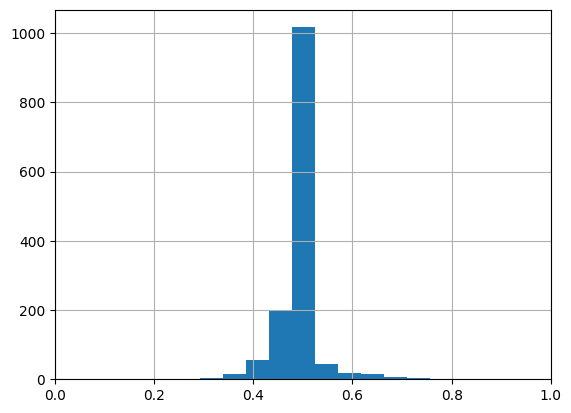

In [65]:
pd.Series(foo_norm[:,0]).hist()
plt.xlim(0,1)

(0.0, 1.0)

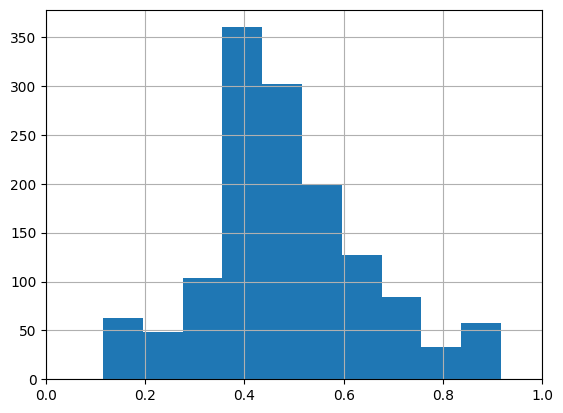

In [66]:
pd.Series(foo_norm[:,10]).hist()
plt.xlim(0,1)